Цель задания: изучить работу с готовыми моделями из torchvision.

Контекст
Вам необходимо подобрать базовую модель для работы по вашей задаче. Вы пробуете обучать различные модели на “ваших” данных. По результатам отберёте лучшую для дальнейшего обучения.

Задание
Вам необходимо провести эксперименты по начальному обучению различных моделей и сравнить результаты.

Возьмите датасет EMNIST из torchvision
Обучите на нём модели: ResNet 18, VGG 16, Inception v3, DenseNet 161 (с нуля по 10 эпох)
Сведите результаты обучения моделей (графики лоса) в таблицу и сравните их.
Задание со звездочкой*
Выполните то же задание, используя датасет hymenoptera_data

Инструкция к выполнению задания

Загрузите датасет, посмотрите примеры картинок в нём и проверьте наличествующие классы и их дисбаланс.
Создайте модель текущего типа, используя интерфейс torchvision для нужного количества классов.
Обучите модель с нуля 10 эпох. Фиксируйте значение функции потерь в список для последующего отображения.
Повторите пункты 2 и 3 для всех указанных вариантов моделей.
Формат сдачи работы
Прикрепите ссылку на готовое решение в личном кабинете. Работу можно отправлять в виде ссылки на python-ноутбук из GitHub, Google Colaboratory или аналогичных платформ. Не забудьте открыть доступ на просмотр и комментирование.

Критерии оценивания
По итогу выполнения задания вы получите зачёт.

Задание считается выполненным, если:

вы обучили каждую модель до некоторого улучшения качества
составлена таблица обучения для сравнения
Задание будет отправлено на доработку, если:

использованы не все типы моделей
не составлена сводная таблица с результатами

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch import nn
import torch.utils.data as data_utils
import torchvision as tv
from torchsummary import summary
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


Функции, которые помогут отслеживать память и сохранять промежуточные значения, чтобы не допустить превышения лимитов.

In [ ]:
import inspect
import pickle
import os
import sys
base_dir = '/content/drive/MyDrive/tmp/'
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def show_memory_usage(objs=locals().items()):
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in objs), key=lambda x: -x[1])[:10]:
        if name[0] != '_' and name not in ['rcParams', 'rcParamsDefault', 'rcParamsOrig', 'sctypeNA']:
            print(f"{name:>30}: {sizeof_fmt(size):>8}")

def save_pickle(obj, fname, dir=base_dir):
    full_fname = dir + '/' + fname
    with open(full_fname, 'wb') as pickle_file:
        pickle.dump(obj, pickle_file)
    print(f"saved \"{fname}\" ({sizeof_fmt(os.path.getsize(full_fname))}).")

def load_pickle(fname, dir=base_dir):
    full_fname = dir + '/' + fname
    with open(full_fname, 'rb') as pickle_file:
        obj = pickle.load(pickle_file)
    print(f"loaded \"{fname}\" ({sizeof_fmt(os.path.getsize(full_fname))}).")
    return obj

In [ ]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
def train(net_name, net, train_iter, test_iter, trainer, num_epochs):
    Loss_train_list = []
    Accuracy_train_list = []
    Accuracy_test_list = []

    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum') # используем категорийную кроссэнтропию и суммируем ошибки - чтобы сильнее их выделить
    net.train() # переключаем сеть в режим обучения
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device)) # считаем аккураси на тестовых данных
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

        Loss_train_list.append(train_l_sum / n)
        Accuracy_train_list.append(train_acc_sum / n)
        Accuracy_test_list.append(test_acc)

    x1 = range(0, num_epochs)
    x2 = range(0, num_epochs)
    x3 = range(0, num_epochs)
    y1 = Loss_train_list
    y2 = Accuracy_train_list
    y3 = Accuracy_test_list
    #print(f'')
    fig, ax = plt.subplots(3,1)
    fig.set_figwidth(6)
    fig.set_figheight(12)
    fig.suptitle('loss & accuracy')
    ax[0].plot(x1, y1, 'o-')
    ax[0].set_xlabel('train loss vs. epoches')
    ax[0].set_ylabel('train loss')
    ax[1].plot(x2, y2, '.-')
    ax[1].set_xlabel('train accuracy vs. epoches')
    ax[1].set_ylabel('train accuracy')
    ax[2].plot(x3, y3, '.-')
    ax[2].set_xlabel('test accuracy vs. epoches')
    ax[2].set_ylabel('test accuracy')
    plt.show()
    path_png = "/content/drive/MyDrive/tmp/" + net_name + ".png"
    fig.savefig(path_png, format='png')

    save_pickle(Loss_train_list,net_name + '_' + 'Loss_train_list' + '.pickle',base_dir)
    save_pickle(Accuracy_train_list,net_name + '_' + 'Accuracy_train_list' + '.pickle',base_dir)
    save_pickle(Accuracy_test_list,net_name + '_' + 'Accuracy_test_list' + '.pickle',base_dir)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## DataSet

EMNIST ByClass: 697 932 characters. 62 unbalanced classes.

EMNIST ByMerge: 697 932 characters. 47 unbalanced classes.

EMNIST Balanced: 112 800 characters. 47 balanced classes.

EMNIST Letters: 124 800 characters. 26 balanced classes.

EMNIST Digits: 240 000 characters. 10 balanced classes.

EMNIST MNIST: 60 000 characters. 10 balanced classes.

<font color=green size=3>
Видим, что полных набора 3.
<br>
Из них:
<br>
<br>
EMNIST Balanced - специально сбалансированный, для облегчения обучения.
<br>
EMNIST ByClass - самый полный  и несбалансированный.
<br>
Будем использовать и тот и другой, чтобы посмотреть на разницу для обучения.
<br>
</font>

In [ ]:
BATCH_SIZE = 256
indices = torch.arange(1000)

transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3), # предобученные модели работают с 3х канальными рисунками, поэтому искусственно делаем из одного три канала
    tv.transforms.Resize((224, 224)), # трансформируем наши изображения до требуемого размера
    tv.transforms.ToTensor()
])
train_dataset_bc = tv.datasets.EMNIST(root="./data", split='byclass', train=True, transform=transoforms, download=True)
test_dataset_bc = tv.datasets.EMNIST(root="./data", split='byclass', train=False, transform=transoforms, download=True)

#train_dataset_bc_min = data_utils.Subset(train_dataset_bc, indices)
#test_dataset_bc_min = data_utils.Subset(test_dataset_bc, indices)
#train_iter_bc = torch.utils.data.DataLoader(train_dataset_bc_min, batch_size=BATCH_SIZE)
#test_iter_bc = torch.utils.data.DataLoader(test_dataset_bc_min, batch_size=BATCH_SIZE)
# уменьшаем выборку данных, чтобы протестировать код на cpu быстрее

train_iter_bc = torch.utils.data.DataLoader(train_dataset_bc, batch_size=BATCH_SIZE)
test_iter_bc = torch.utils.data.DataLoader(test_dataset_bc, batch_size=BATCH_SIZE)

#############################################3

train_dataset_bl = tv.datasets.EMNIST(root="./data", split='balanced', train=True, transform=transoforms, download=True)
test_dataset_bl = tv.datasets.EMNIST(root="./data", split='balanced', train=False, transform=transoforms, download=True)

#train_dataset_bl_min = data_utils.Subset(train_dataset_bl, indices)
#test_dataset_bl_min = data_utils.Subset(test_dataset_bl, indices)
#train_iter_bl = torch.utils.data.DataLoader(train_dataset_bl_min, batch_size=BATCH_SIZE)
#test_iter_bl = torch.utils.data.DataLoader(test_dataset_bl_min, batch_size=BATCH_SIZE)
# уменьшаем выборку данных, чтобы протестировать код на cpu быстрее


train_iter_bl = torch.utils.data.DataLoader(train_dataset_bl, batch_size=BATCH_SIZE)
test_iter_bl = torch.utils.data.DataLoader(test_dataset_bl, batch_size=BATCH_SIZE)

100%|██████████| 561753746/561753746 [00:28<00:00, 19835936.07it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


<font color=green size=3>
ResNet18 feature extraction  
<br>
EMNIST ByClass
<br>
</font>

In [ ]:
model_name = 'model_resnet_bc'
model_resnet_bc = tv.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s]


In [ ]:
model_resnet_bc = model_resnet_bc.to(device)

In [ ]:
print(model_resnet_bc)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model_resnet_bc.to(device), input_size=(3, 224, 224)) # проверяем размерности архитектуры

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
# Убираем требование градиента:
for param in model_resnet_bc.parameters():
    param.requires_grad = False # Замораживаем веса. Мы их менять не будем.

In [ ]:
model_resnet_bc.fc = nn.Linear(in_features=512, out_features=62).to(device)

In [ ]:
print("Params to learn:") # выпишем в список, какие параметры будут дообучаться (изменяться под новую задачу)
params_to_update = []
for name, param in model_resnet_bc.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


Step 0. time since epoch: 1.060. Train acc: 0.020. Train Loss: 4.317
Step 10. time since epoch: 7.321. Train acc: 0.029. Train Loss: 4.188
Step 20. time since epoch: 13.148. Train acc: 0.044. Train Loss: 4.054
Step 30. time since epoch: 19.947. Train acc: 0.052. Train Loss: 3.961
Step 40. time since epoch: 25.678. Train acc: 0.059. Train Loss: 3.891
Step 50. time since epoch: 32.212. Train acc: 0.063. Train Loss: 3.839
Step 60. time since epoch: 38.387. Train acc: 0.072. Train Loss: 3.789
Step 70. time since epoch: 44.115. Train acc: 0.082. Train Loss: 3.745
Step 80. time since epoch: 51.024. Train acc: 0.092. Train Loss: 3.704
Step 90. time since epoch: 56.803. Train acc: 0.102. Train Loss: 3.668
Step 100. time since epoch: 63.200. Train acc: 0.113. Train Loss: 3.637
Step 110. time since epoch: 69.438. Train acc: 0.124. Train Loss: 3.607
Step 120. time since epoch: 75.185. Train acc: 0.135. Train Loss: 3.576
Step 130. time since epoch: 82.164. Train acc: 0.145. Train Loss: 3.547
Step 

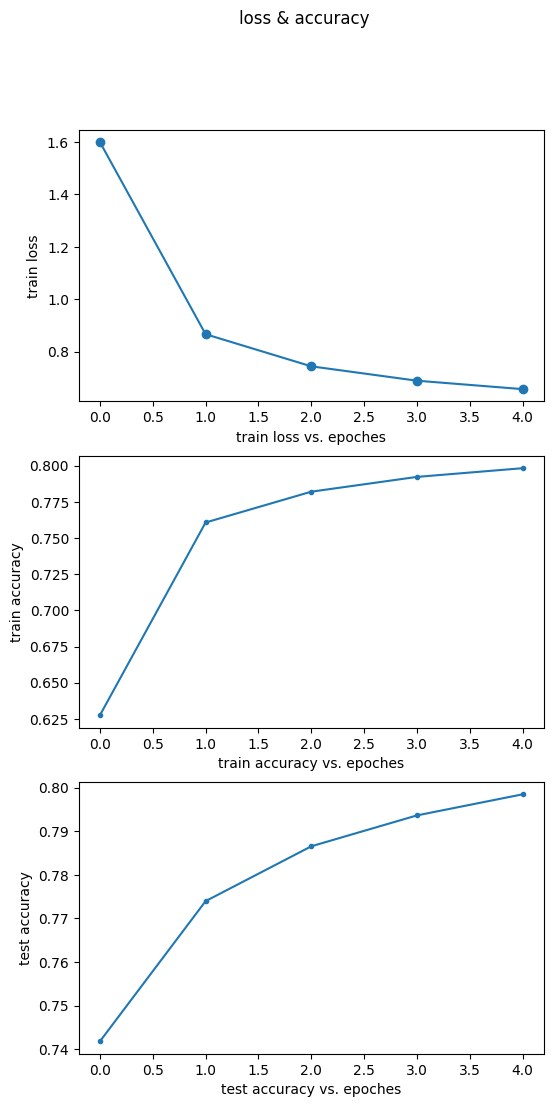

saved "model_resnet_bc_Loss_train_list.pickle" (61.0 B).
saved "model_resnet_bc_Accuracy_train_list.pickle" (61.0 B).
saved "model_resnet_bc_Accuracy_test_list.pickle" (61.0 B).
CPU times: user 2h 17min 16s, sys: 22min 24s, total: 2h 39min 40s
Wall time: 2h 40min 34s


In [ ]:
%%time
lr, num_epochs = 0.0001, 5
trainer = torch.optim.Adam(params_to_update, lr=lr)
train(model_name, model_resnet_bc, train_iter_bc, test_iter_bc, trainer, num_epochs)

In [ ]:
path_model = base_dir + model_name + '.pt'
torch.save(model_resnet_bc.state_dict(), path_model)

In [ ]:
torch.cuda.empty_cache()

<font color=green size=3>
ResNet18 feature extraction  
<br>
EMNIST Balanced
<br>
</font>

In [ ]:
model_name = 'model_resnet_bl'
model_resnet_bl = tv.models.resnet18(pretrained=True)

In [ ]:
model_resnet_bl = model_resnet_bl.to(device)

In [ ]:
print(model_resnet_bl)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model_resnet_bl.to(device), input_size=(3, 224, 224)) # проверяем размерности архитектуры

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
# Убираем требование градиента:
for param in model_resnet_bl.parameters():
    param.requires_grad = False # Замораживаем веса. Мы их менять не будем.

In [ ]:
model_resnet_bl.fc = nn.Linear(in_features=512, out_features=47).to(device)

In [ ]:
print("Params to learn:") # выпишем в список, какие параметры будут дообучаться (изменяться под новую задачу)
params_to_update = []
for name, param in model_resnet_bl.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


Step 0. time since epoch: 0.702. Train acc: 0.031. Train Loss: 4.031
Step 10. time since epoch: 6.732. Train acc: 0.034. Train Loss: 3.957
Step 20. time since epoch: 13.388. Train acc: 0.034. Train Loss: 3.912
Step 30. time since epoch: 19.916. Train acc: 0.035. Train Loss: 3.874
Step 40. time since epoch: 25.887. Train acc: 0.042. Train Loss: 3.838
Step 50. time since epoch: 33.010. Train acc: 0.047. Train Loss: 3.810
Step 60. time since epoch: 39.059. Train acc: 0.054. Train Loss: 3.782
Step 70. time since epoch: 45.760. Train acc: 0.060. Train Loss: 3.754
Step 80. time since epoch: 52.127. Train acc: 0.068. Train Loss: 3.729
Step 90. time since epoch: 58.293. Train acc: 0.076. Train Loss: 3.702
Step 100. time since epoch: 65.273. Train acc: 0.085. Train Loss: 3.677
Step 110. time since epoch: 71.243. Train acc: 0.095. Train Loss: 3.652
Step 120. time since epoch: 78.217. Train acc: 0.105. Train Loss: 3.627
Step 130. time since epoch: 84.373. Train acc: 0.114. Train Loss: 3.602
Step 

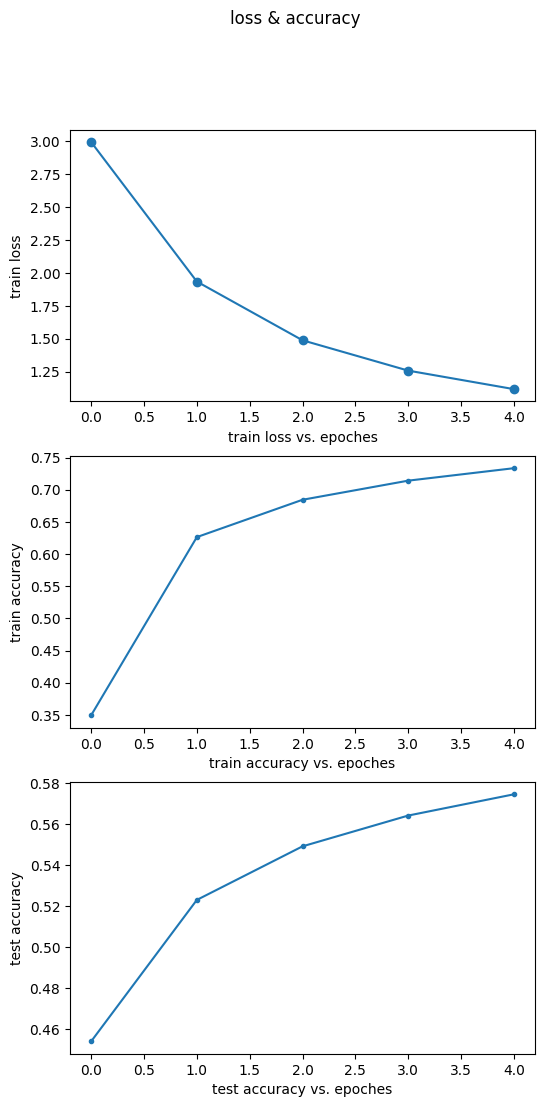

saved "model_resnet_bl_Loss_train_list.pickle" (61.0 B).
saved "model_resnet_bl_Accuracy_train_list.pickle" (61.0 B).
saved "model_resnet_bl_Accuracy_test_list.pickle" (61.0 B).
CPU times: user 33min 57s, sys: 6min 14s, total: 40min 12s
Wall time: 40min 34s


In [ ]:
%%time
lr, num_epochs = 0.0001, 5
trainer = torch.optim.Adam(params_to_update, lr=lr)
train(model_name, model_resnet_bl, train_iter_bl, test_iter_bc, trainer, num_epochs)

In [ ]:
path_model = base_dir + model_name + '.pt'
torch.save(model_resnet_bl.state_dict(), path_model)

In [ ]:
torch.cuda.empty_cache()

<font color=green size=3>
Это шаблон примечания
<br>
<br>
</font>